In [1]:
%matplotlib inline
import numpy as np
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import pandas as pd
import dask
import os.path
import sh
from __future__ import division
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['contour.negative_linestyle']= 'dashed'

from progress_bar import *
from useful import *
import gradients as gr

global data_dir
data_dir = '/scratch/ap587/dry_data/'

plot_dir = '/scratch/ap587/plots/poster1/'
mkdir = sh.mkdir.bake('-p')
mkdir(plot_dir)

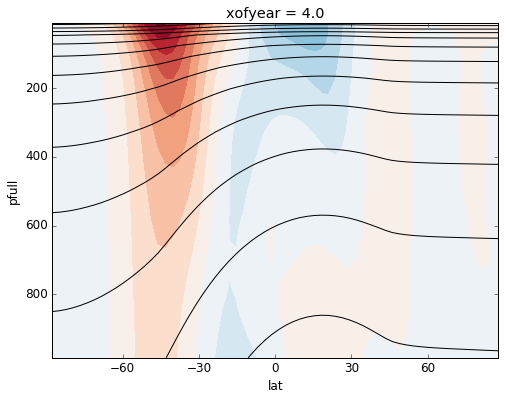

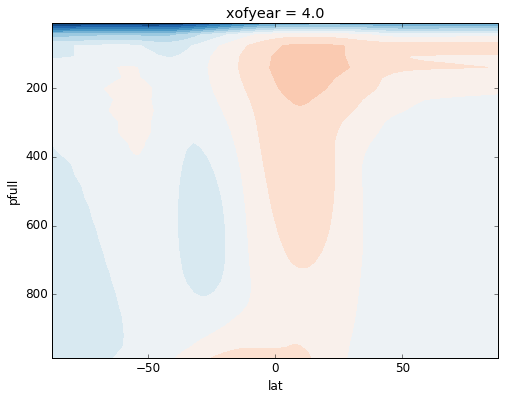

In [67]:
exp = 'exp5_obl45.0'
#exp = 'exp2_hc50.0'
ds = open_zmean_runset('/scratch/ap587/dry_data/', exp)
ds = ds.isel(time=slice(720,None))
lag = calc_seasonal_lag(ds.teq)
ds.coords['xofyear'] = np.mod( ds.time+45+lag, 360.) //90 + 1
ds = ds.groupby('xofyear').mean('time')


ds.teq.isel(xofyear=3).plot.contour(x='lat',y='pfull',levels=15,colors='k',add_colorbar=False)
ds.ucomp.isel(xofyear=3).plot.contourf(x='lat',y='pfull',levels=21,add_colorbar=False)
plt.gca().invert_yaxis()
plt.gca().set_xticks(np.arange(-60,61,30))

fig,ax = plt.subplots()
(ds.teq-ds.temp).isel(xofyear=3).plot.contourf(x='lat',y='pfull',levels=21,add_colorbar=False)
ax.invert_yaxis()

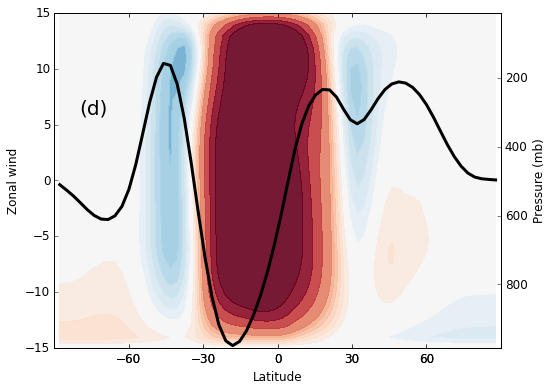

In [56]:
fig, ax1 = plt.subplots()

levels = [-15e10, -12e10, -9e10, -6e10,-5e10, -4e10, -3e10, -2e10,
          -1e10, 1e10, 2e10, 3e10, 4e10,5e10, 6e10, 9e10, 12e10, 15e10]
        
x = ds.lat.values
y = ds.pfull.values #np.linspace(-8,8,len(data.pfull.values))
X,Y = np.meshgrid(x,y)
psi = ds.psi.isel(xofyear=3)
#psi = np.tile(psi,(len(y),1)) only use if want to fill with one pressure level
cs = ax1.contourf(X, Y, psi, levels, cmap='RdBu_r', alpha=0.9, add_colorbar=False, extend='both')
cs.set_clim([-15e10,15e10])
ax1.yaxis.set_label_position('right')
ax1.set_ylabel('Pressure (mb)')
ax1.invert_yaxis()
ax1.yaxis.tick_right()

ax2 = fig.add_subplot(111,sharex=ax1,frameon=False)

ax2.yaxis.tick_left()
f1 = ds.ucomp.isel(xofyear=i).isel(pfull=-1).plot(ax=ax2,color='k',label='ucomp',lw=3)

ax2.set_title('')
        
ax2.set_ylabel('')
ax2.set_xlabel('Latitude')
ax2.set_xticks(np.arange(-60,61,30))
ax2.set_xlim([-90,90])
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('Zonal wind')
        
ax2.text(-80,6, '(d)', color='k', fontsize=20)

74
56
75
76


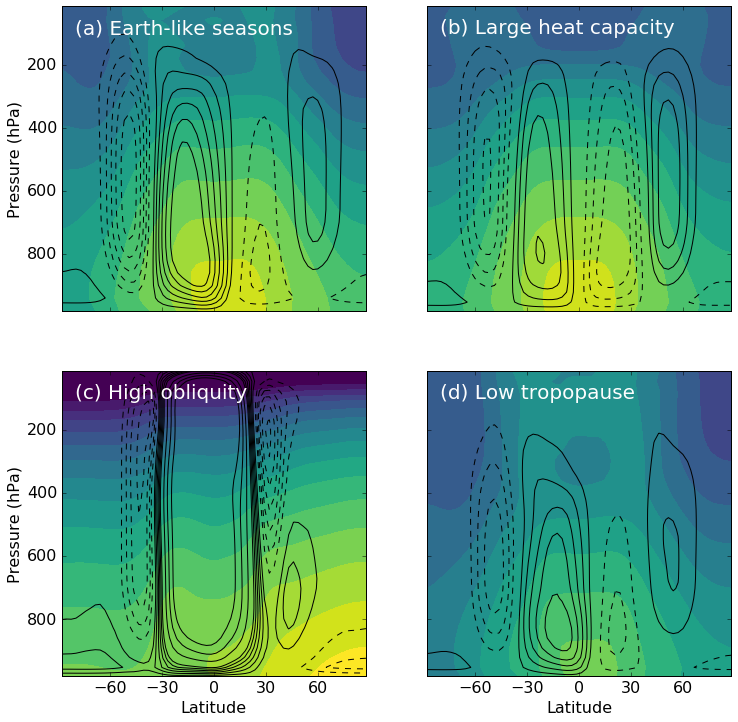

In [2]:
# plot the temperatures and mass streamfunction for four S-W experiments to show possiblities
exps = ['exp2_hc50.0', 'exp4_HS_hc2000.0', 'exp5_obl60.0', 'exp8-ml50_tau0.1']

levels = np.append(np.linspace(-9e10,-5e10,3),np.linspace(-3e10,3e10,9))
levels = np.append(levels, np.linspace(5e10,9e10,3))
levels = [-1e20,-15e10, -12e10, -9e10, -6e10,-5e10, -4e10, -3e10, -2e10, -1e10, 1e10, 2e10, 3e10, 4e10,5e10, 6e10, 9e10, 12e10, 15e10,1e20]


tlevels = np.arange(150,301,10)
plot_labels = ['(a) Earth-like seasons', '(b) Large heat capacity', 
               '(c) High obliquity', '(d) Low tropopause']

fig, axs = plt.subplots(2,2,figsize=(12,12),dpi=200, sharey=True, sharex=True)
for i, ax in enumerate(axs.reshape(-1)):
    ds = open_zmean_runset(data_dir, exps[i])
    ds = ds.isel(time=slice(720,None))
    
    x = ds.lat.values
    y = ds.pfull.values
    X,Y = np.meshgrid(x,y)
        
    lag = calc_seasonal_lag(ds.teq)
    print lag
    summer = np.arange(45,135) + lag
    ds = ds.groupby('day').mean('time')
    ds.temp.isel(day=summer).mean('day').plot.contourf(x='lat',y='pfull',ax=ax,levels=tlevels,
                                                          add_colorbar=False,cmap='viridis')
    ax.contour(X,Y,ds.psi.isel(day=summer).mean('day'),levels=levels,
               colors='k',add_colorbar=False, lw=3)
    #ds.p_trop.isel(day=summer).mean('day').plot.line(ax=ax,color='r')
    #ds.psi.isel(day=summer).mean('day').plot.contour(x='lat',y='pfull',ax=ax, levels=levels,
    #                                                  colors='k',add_colorbar=False)

    ax.set_xticks(np.arange(-60,61,30))
    ax.set_xlabel('')
    ax.set_ylabel('')
    if i in [0,2]:
        ax.set_ylabel('Pressure (hPa)')
    if i in [2,3]:
        ax.set_xlabel('Latitude')

    ax.text(-80,100, plot_labels[i], color='w', fontsize=20)
    
ax.invert_yaxis()
plt.savefig(plot_dir + 'fig2_summers_latpfull.png', dpi=200,bbox_inches='tight',transparent=True)

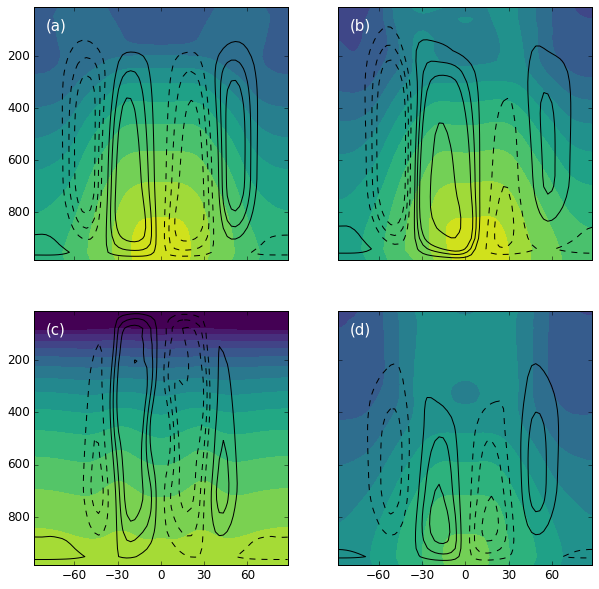

In [3]:
# plot the temperatures and mass streamfunction for four experiments to show possiblities in the model
exps = ['exp4_HS_hc2000.0', 'exp2_hc50.0', 'exp5_obl60.0', 'exp8_tau0.1']

levels = np.append(np.linspace(-9e10,-5e10,3),np.linspace(-3e10,3e10,9))
levels = np.append(levels, np.linspace(5e10,9e10,3))
levels = [-12e10, -9e10, -6e10, -3e10, -2e10, -1e10, 1e10, 2e10, 3e10, 6e10, 9e10, 12e10]

tlevels = np.arange(150,301,10)
plot_labels = ['(a)', '(b)', '(c)', '(d)']

fig, axs = plt.subplots(2,2,figsize=(10,10),dpi=200, sharey=True, sharex=True)
for i, ax in enumerate(axs.reshape(-1)):
    ds = open_zmean_runset(data_dir, exps[i])
    ds = ds.isel(time=slice(720,None))
    
    x = ds.lat.values
    y = ds.pfull.values
    X,Y = np.meshgrid(x,y)
        
    if exps[i] == 'exp2_hc50.0':
        lag = calc_seasonal_lag(ds.teq)
        summer = np.arange(135,225)# + lag
        ds = ds.groupby('day').mean('time')
        ds.temp.isel(day=summer).mean('day').plot.contourf(x='lat',y='pfull',ax=ax,levels=tlevels,
                                                          add_colorbar=False,cmap='viridis')
        ax.contour(X,Y,ds.psi.isel(day=summer).mean('day'),levels=levels,
                    colors='k',add_colorbar=False)
        #ds.psi.isel(day=summer).mean('day').plot.contour(x='lat',y='pfull',ax=ax, levels=levels,
        #                                                  colors='k',add_colorbar=False)
    else:
        ds.temp.mean('time').plot.contourf(x='lat',y='pfull',ax=ax,levels=tlevels,
                                           add_colorbar=False,cmap='viridis')
        ax.contour(X,Y,ds.psi.mean('time'),levels=levels,colors='k',add_colorbar=False)
    ax.set_xticks(np.arange(-60,61,30))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.text(-80,100, plot_labels[i], color='w', fontsize=15)
    
ax.invert_yaxis()
plt.savefig(plot_dir + 'fig2_latpfull.png', dpi=200)

In [5]:
exps = ['exp4_HS_hc2000.0', 'exp2_hc50.0', 'exp5_obl60.0', 'exp8_tau0.1']
for i in range(4):
    #plt.subplots(figsize=(20,8),dpi=200)
    ds = open_runset(data_dir,exps[i],range(9,100))
    ds.time.data = ds.time.data/24 - 1
    ds.coords['day'] = ds.time%360
    


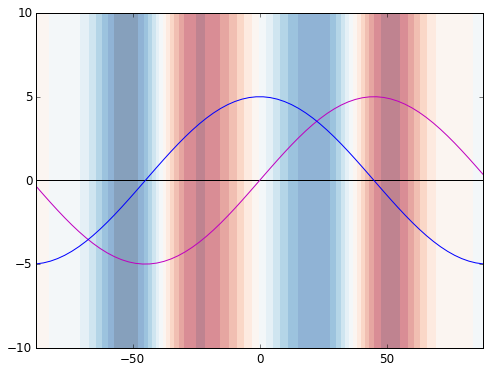

In [56]:
exp = 'exp4_HS_hc2000.0'
ds = open_zmean_runset(data_dir,exp)
ds = ds.isel(time=slice(720,None))
plt.subplots()
x = ds.lat.values
y = np.linspace(-10,10,2)
X,Y = np.meshgrid(x,y)

psi = ds.psi.sel(pfull=500,method='nearest').mean('time')
plt.contourf(X,Y,np.tile(psi,(len(y),1)),15,cmap='RdBu_r',alpha=0.5)
plt.axhline(0,color='k',lw=1)
plt.plot(x,5*np.sin(2*x*np.pi/180), 'm')
plt.plot(x,5*np.cos(2*x*np.pi/180), 'b')



76


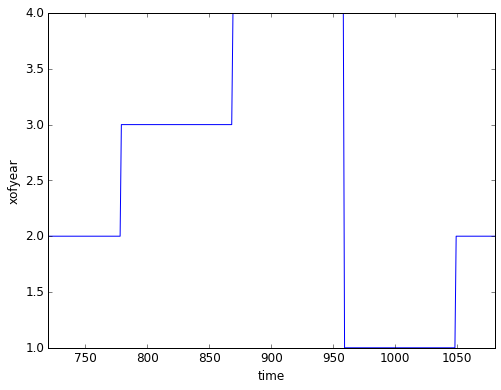

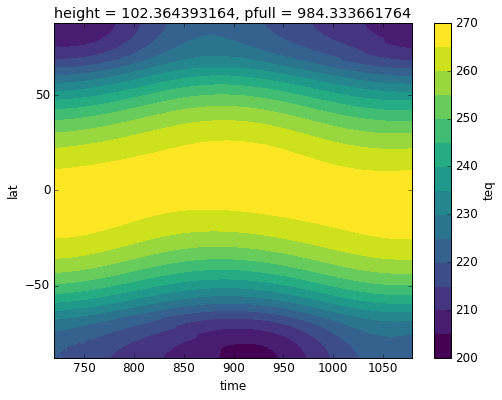

In [9]:
ds = open_zmean_runset(data_dir,exps[3])
ds = ds.isel(time=slice(720,None))
lag = calc_seasonal_lag(ds.teq)
print lag
ds.coords['xofyear'] = np.mod( ds.time+45+lag, 360.) //90 + 1
ds.xofyear.plot()
plt.gca().set_xlim([720,1080])
plt.subplots()
ds.teq.isel(pfull=-1).isel(time=slice(0,360)).plot.contourf(x='time',y='lat',levels=15)

In [ ]:

fig1, ax1 = plt.subplots()
exp = 'exp1_HS1.0'
ds_hs = open_zmean_runset(data_dir,exp)
ds_hs = ds_hs.isel(time=slice(720,None))
ds_hs.groupby('day').mean('time').teq.isel(pfull=-1).plot.contourf(x='day',y='lat',levels=15,ax=ax1)
ax1.set_title('')
ax1.set_xticks(np.arange(45,316,45))
ax1.set_yticks(np.arange(-60,61,30))
plt.grid()

fig2, ax2 = plt.subplots()
exp = 'exp2_hc50.0'
ds = open_zmean_runset(data_dir,exp)
ds = ds.isel(time=slice(720,None))
ds.groupby('day').mean('time').teq.isel(pfull=-1).plot.contourf(x='day',y='lat',levels=15,ax=ax2)
#ds.groupby('day').mean('time').teq.isel(pfull=-1).plot.contour(x='day',y='lat',levels=11,ax=ax2, colors='k', add_colorbar=False)
ax2.set_title('')
ax2.set_yticks(np.arange(-60,61,30))
ax2.set_xticks(np.arange(45,316,45))
plt.grid()

In [ ]:
exp = 'exp2_hc50.0'
ds_zmean = open_zmean_runset(data_dir,exp)
ds_zmean = ds_zmean.isel(time=slice(720,None))
ds = open_runset(data_dir,exp,runs=range(9,100))
ds.time.data = ds.time.data/24 - 1
ds.coords['day'] = ds.time%360 
ds['emf'] = (('time','pfull','lat','lon'), -86400. * gr.ddx( (ds.ucomp_sq - ds.ucomp**2)))
ds = ds.mean('lon')

dsg = ds_zmean.groupby('day').mean('time')
dsfg = ds.groupby('day').mean('time')
winter = np.arange(135,225)
equinox = np.append(np.arange(225,315), np.arange(45,135))

fig,ax = plt.subplots()
dsg.psi.isel(day=winter).mean('day').plot.contourf(x='lat',y='pfull',ax=ax,levels=15)
dsfg.emf.isel(day=winter).mean('day').plot.contour(x='lat',y='pfull',ax=ax,color='k', levels=11)
ax.invert_yaxis()
ax.set_xticks(np.arange(-60,61,30))
plt.grid()

fig,ax = plt.subplots()
dsg.psi.isel(day=equinox).mean('day').plot.contourf(x='lat',y='pfull',ax=ax,levels=15)
dsfg.emf.isel(day=equinox).mean('day').plot.contour(x='lat',y='pfull',ax=ax,color='k', levels=11)
ax.invert_yaxis()
ax.set_xticks(np.arange(-60,61,30))
plt.grid()

In [ ]:
print ds